### LIBRERIAS

In [ ]:
import os, io
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
%matplotlib inline
import matplotlib.pyplot as plt

### CARAGA DE LOS DATOS Y PREPROCESADO

Aplicamos a los datos el preprocesado de los datos explicado en el EDA

In [3]:
base_dir= "DATA"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "valid")
test_dir = os.path.join(base_dir, "test")

classes = ['melanoma', 'seborrheic_keratosis', 'nevus']

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)


val_test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
classes = ['melanoma', 'nevus', 'seborrheic_keratosis']

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,           
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    classes=classes,
    class_mode='categorical',
    shuffle=False
)


Found 1002 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 599 images belonging to 3 classes.


In [ ]:

#  Definición de la CNN
model = models.Sequential([
    layers.InputLayer(shape=(*IMG_SIZE, 3)),  # entrada 224x224x3
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(3, activation='softmax')      # salida 3 clases
])


# Compilación
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks para controlar el entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_skin_cnn.keras", save_best_only=True, monitor="val_loss", verbose=1)

]


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,680,067 (36.93 MB)

 Trainable params: 9,680,067 (36.93 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Entrenamiento
history = model.fit(
    train_generator,
    epochs = 30,
    validation_data = val_generator,
    callbacks = callbacks
)


Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3571 - loss: 1.1042
Epoch 1: val_loss improved from inf to 1.09023, saving model to best_skin_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.3572 - loss: 1.1037 - val_accuracy: 0.2067 - val_loss: 1.0902
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4424 - loss: 1.0566
Epoch 2: val_loss improved from 1.09023 to 1.03315, saving model to best_skin_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4425 - loss: 1.0562 - val_accuracy: 0.5200 - val_loss: 1.0332
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4280 - loss: 1.0218
Epoch 3: val_loss improved from 1.03315 to 1.01404, saving model to best_skin_cnn.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.4284 - loss: 1.0216 - val_accuracy: 0.3400 - val_loss: 1.0140
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4578 - loss: 0.9876
Epoch 4: val_loss improved from 1.01404 to 0.99973, saving mode

In [10]:

# Evaluación en test
test_loss, test_acc = model.evaluate( test_generator, steps = test_generator.samples // BATCH_SIZE)
print(f"Precisión en test: {test_acc:.3f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step - accuracy: 0.4128 - loss: 0.9598
Precisión en test: 0.580


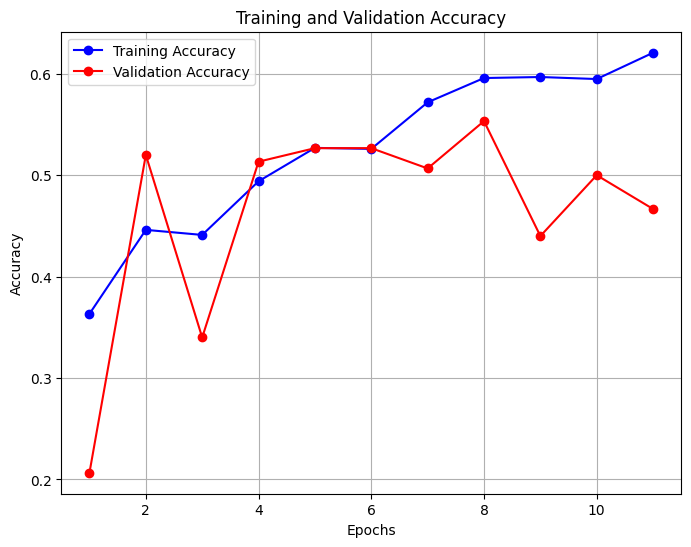

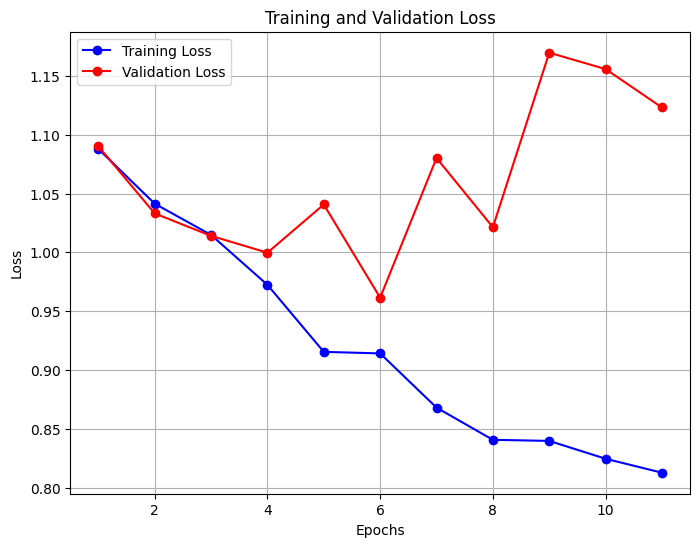

In [ ]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs, acc,    'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc,'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot de loss
plt.figure(figsize=(8,6))
plt.plot(epochs, loss,     'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.show()
